In [59]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [99]:
#Load Datasets

## load Cleaned Data
cleaned_data = pd.read_csv("cleaned_data.csv", index_col="GEOID")
cleaned_data.index = cleaned_data.index.astype(int)

## load solar adoption data
adoption_data = pd.read_csv('data/solar_demographic_tract_level_data.csv', index_col=0)
adoption_data = adoption_data.rename(columns={'tract': 'GEOID'})

## load geospatial data
tracts_geodata = gpd.read_file('tracts.geojson')
tracts_geodata = tracts_geodata.set_index('GEOID')
tracts_geodata.index = tracts_geodata.index.astype(int)

/var/folders/67/r87g720s2653g554zdhtz1vh0000gn/T/ipykernel_1648/1872996661.py:4: DtypeWarning: Columns (181) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv("cleaned_data.csv", index_col="GEOID")


In [147]:
#Fix data types
adoption_data['bin_description'] = adoption_data['bin_description'].astype(str)

#Filter out data for only income by AMI bin
ami_adoption_data = adoption_data[adoption_data['bin_description'].str.contains('AMI Bin:')]
print("# of Census Tracts in original dataset: "+str(len(ami_adoption_data['GEOID'].unique())))

grouped_adoption_data = ami_adoption_data.groupby(['GEOID', 'year']).sum().reset_index()

#Merge population from cleaned data to adoption dataset
combined_data = grouped_adoption_data.merge(cleaned_data[['total_pop', 'yearly_sunlight_kwh_median', 'kw_median' ]], left_on='GEOID', right_index=True)
print("# of Census Tracts after merging : "+str(len(combined_data['GEOID'].unique())))

# Calculate the adoption rate for each year
combined_data['adoption_rate'] = combined_data['N'] / combined_data['total_pop'] * 100


# of Census Tracts in original dataset: 17008
# of Census Tracts after merging : 5145


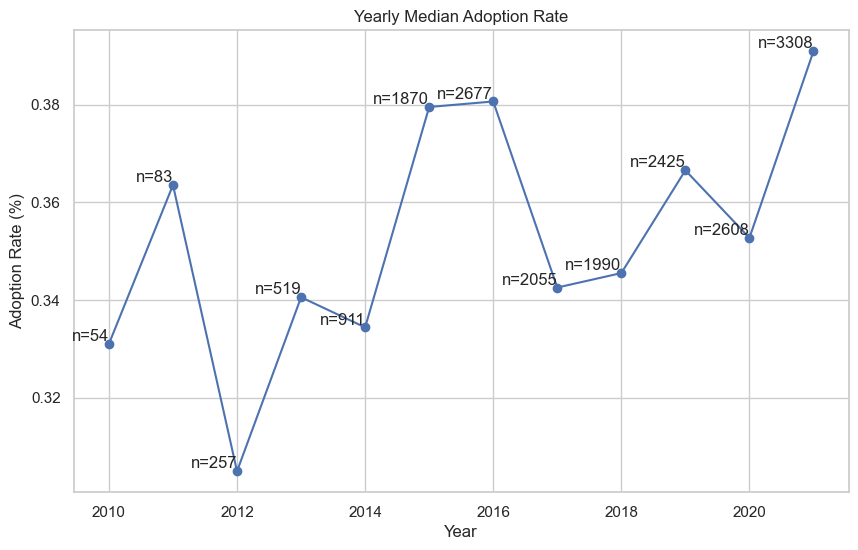

In [110]:
#Plot adoption rate

grouped_data = combined_data.groupby(['bin_description', 'year'])['adoption_rate'].median().reset_index()

grouped_data_count = combined_data.groupby(['bin_description', 'year'])['adoption_rate'].count().reset_index()
# grouped_data = combined_data[combined_data['GEOID'] == 4013040506]

plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size
for bin_desc in grouped_data['bin_description'].unique():
    bin_data = grouped_data[grouped_data['bin_description'] == bin_desc]
    plt.plot(bin_data['year'], bin_data['adoption_rate'], marker='o', label=bin_desc)

# Annotate each data point with the corresponding count
    for idx, row in bin_data.iterrows():
        count = grouped_data_count[(grouped_data_count['bin_description'] == row['bin_description']) & 
                                   (grouped_data_count['year'] == row['year'])]['adoption_rate'].values[0]
        plt.text(row['year'], row['adoption_rate'], f'n={count}', ha='right', va='bottom')


plt.xlabel('Year')
plt.ylabel('Adoption Rate (%)')
plt.title('Yearly Median Adoption Rate')
# plt.legend(title='Income Category')
plt.grid(True)  # Optional: Show gridlines
# plt.show()

In [168]:
# Extrapolate data

# Convert 'year' column to numeric
combined_data['year'] = pd.to_numeric(combined_data['year'])

# Group the data by 'GEOID' and 'bin_description'
grouped_data = combined_data.groupby(['GEOID'])

# Create a new DataFrame to store the extrapolated data
extrapolated_data = pd.DataFrame(columns=['GEOID', 'year', 'adoption_rate'])


# Extrapolate adoption rate for each group
def extrapolate_group(group_data):
# for (geoid, bin_desc), group_data in grouped_data:
    x = group_data['year'].values.reshape(-1, 1)
    y = group_data['adoption_rate'].values
    min_year = x.min()

    # Create and fit a linear regression model
    model = LinearRegression()
    model.fit(x, y)

    # Extrapolate from last year of data to 2025
    future_years = np.arange(min_year + 1, 2026).reshape(-1, 1)
    predictions = model.predict(future_years)

    # Create a DataFrame with extrapolated data for the current group
    group_extrapolated = pd.DataFrame({'GEOID': [group_data['GEOID'].iloc[0]] * len(future_years),
                                       'year': future_years.flatten(),
                                       'adoption_rate': predictions})
    
    return group_extrapolated

# Group the data by 'GEOID' and 'bin_description', and apply the extrapolation function
extrapolated_data = combined_data.groupby(['GEOID']).apply(extrapolate_group).reset_index(drop=True)

# Combine original data and extrapolated data
predicted_adoption_data = pd.concat([combined_data, extrapolated_data], ignore_index=True, join='outer').ffill()

# Print the extrapolated DataFrame
print(predicted_adoption_data)
print(predicted_adoption_data.isna().sum())

              GEOID  year                                    bin_description   
0        4005000400  2021  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...  \
1        4013040506  2010  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
2        4013040506  2011  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
3        4013040506  2012  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
4        4013040506  2013  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
...             ...   ...                                                ...   
106648  55025011506  2021  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
106649  55025011506  2022  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
106650  55025011506  2023  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
106651  55025011506  2024  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
106652  55025011506  2025  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   

          pct     N  total_pop  yearly_

In [170]:
#Create adoption rates for different implementation scenarios

scenario_multiplier = {
    'bau': 1,
    'med': 1.02,
    'high': 1.04
}

#Calculate adoption rate, capacity, and yearly generation for each year for each scenario
predicted_scenario_data = pd.concat([
    predicted_adoption_data.assign(scenario=scenario, 
                         adoption_rate=predicted_adoption_data['adoption_rate'] * multiplier,
                         kw=predicted_adoption_data['adoption_rate'] * multiplier * predicted_adoption_data['kw_median'],
                         yearly_kwh=predicted_adoption_data['adoption_rate'] * multiplier * predicted_adoption_data['yearly_sunlight_kwh_median'])
    for scenario, multiplier in scenario_multiplier.items()
])

# Create a boolean mask to remove the nonsense old data just generated where 'year' < 2021 and 'scenario' is 'high' or 'med'
condition = (predicted_scenario_data['year'] < 2021) & (predicted_scenario_data['scenario'].isin(['high', 'med']))

predicted_scenario_data.reset_index()
# Drop the rows that satisfy the condition
predicted_scenario_data = predicted_scenario_data.loc[~(condition)]

# print(predicted_scenario_data)
print(predicted_scenario_data.sort_values(by='year'))

              GEOID  year                                    bin_description   
3534     6037273200  2010  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...  \
30       4013040514  2010  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
666      4013319403  2010  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
174      4013071505  2010  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
14404   25025080300  2010  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
...             ...   ...                                                ...   
22246    6001444400  2025  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
56362   34035051400  2025  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
56352   34035051200  2025  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
56342   34035051100  2025  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   
106652  55025011506  2025  AMI Bin: <60%AMI Bin: 60-80%AMI Bin: 80-100%AM...   

          pct     N  total_pop  yearly_

<bound method NDFrame.head of year  scenario
2010  bau         0.459608
2011  bau         0.571659
2012  bau         0.540125
2013  bau         0.547039
2014  bau         0.481675
2015  bau         0.483529
2016  bau         0.453572
2017  bau         0.430243
2018  bau         0.428269
2019  bau         0.437511
2020  bau         0.431361
2021  bau         0.451432
      high        0.469490
      med         0.460461
2022  bau         0.442245
      high        0.459935
      med         0.451090
2023  bau         0.457020
      high        0.475301
      med         0.466160
2024  bau         0.471795
      high        0.490666
      med         0.481230
2025  bau         0.486569
      high        0.506032
      med         0.496301
Name: adoption_rate, dtype: float64>


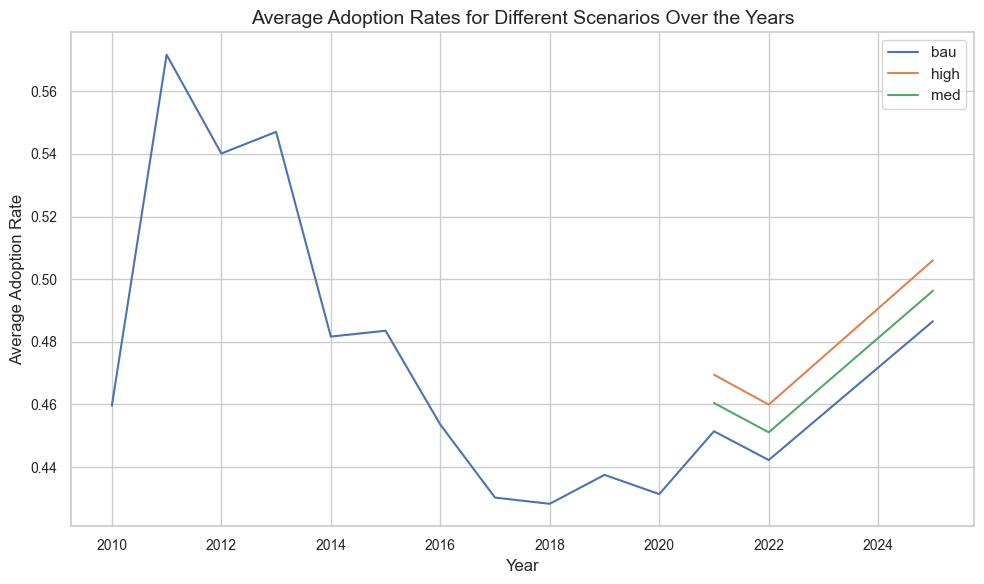

In [171]:
#Map Average adoption rates for each scenario and year

# Calculate the average adoption rates for each scenario and year
average_adoption_rates = predicted_scenario_data.groupby(['year', 'scenario'])['adoption_rate'].mean()

print(average_adoption_rates.head)

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot average adoption rates for each scenario
for scenario in average_adoption_rates.index.get_level_values('scenario').unique():
    ax.plot(average_adoption_rates.loc[:, scenario], label=scenario)

# Customize gridlines
ax.yaxis.grid(True)
ax.set_axisbelow(True)

# Set labels, title, and font size
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Adoption Rate', fontsize=12)
plt.title('Average Adoption Rates for Different Scenarios Over the Years', fontsize=14)

# Customize font size for tick labels and legend
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()




<bound method NDFrame.head of year  scenario
2010  bau           0.471247
2011  bau           2.007295
2012  bau           4.714783
2013  bau          11.689899
2014  bau          19.406120
2015  bau          35.829562
2016  bau          56.005726
2017  bau          65.777044
2018  bau          68.423948
2019  bau          78.131647
2020  bau          85.615462
2021  bau         100.577619
      high        104.600724
      med         102.589172
2022  bau          82.233753
      high         85.523103
      med          83.878428
2023  bau          84.981034
      high         88.380275
      med          86.680655
2024  bau          87.728315
      high         91.237447
      med          89.482881
2025  bau          90.475595
      high         94.094619
      med          92.285107
Name: yearly_kwh, dtype: float64>


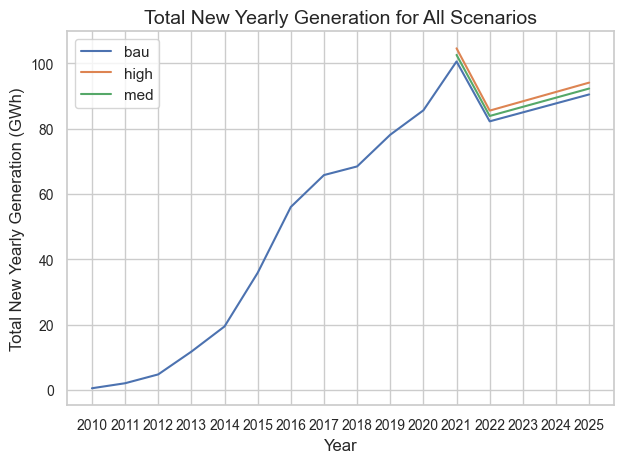

In [173]:
# Calculate the total generation potential for each scenario and year
total_generation = predicted_scenario_data.groupby(['year', 'scenario'])['yearly_kwh'].sum()/1000000

print(total_generation.head)

# Create a figure and axis for the plot
# plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot average adoption rates for each scenario
for scenario in total_generation.index.get_level_values('scenario').unique():
    ax.plot(total_generation.loc[:, scenario], label=scenario)

# Customize gridlines
# ax.yaxis.grid(True)
# ax.set_axisbelow(True)

# Set labels, title, and font size
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total New Yearly Generation (GWh)', fontsize=12)
plt.title('Total New Yearly Generation for All Scenarios', fontsize=14)

# Customize font size for tick labels and legend
plt.xticks(total_generation.index.get_level_values('year').unique(), fontsize=10)  # Set xticks with integer values
plt.yticks(fontsize=10)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

<bound method NDFrame.head of year  scenario
2022  bau         35.267955
      high        36.678674
      med         35.973314
2023  bau         36.446194
      high        37.904042
      med         37.175118
2024  bau         37.624432
      high        39.129410
      med         38.376921
2025  bau         38.802671
      high        40.354778
      med         39.578724
Name: kw, dtype: float64>


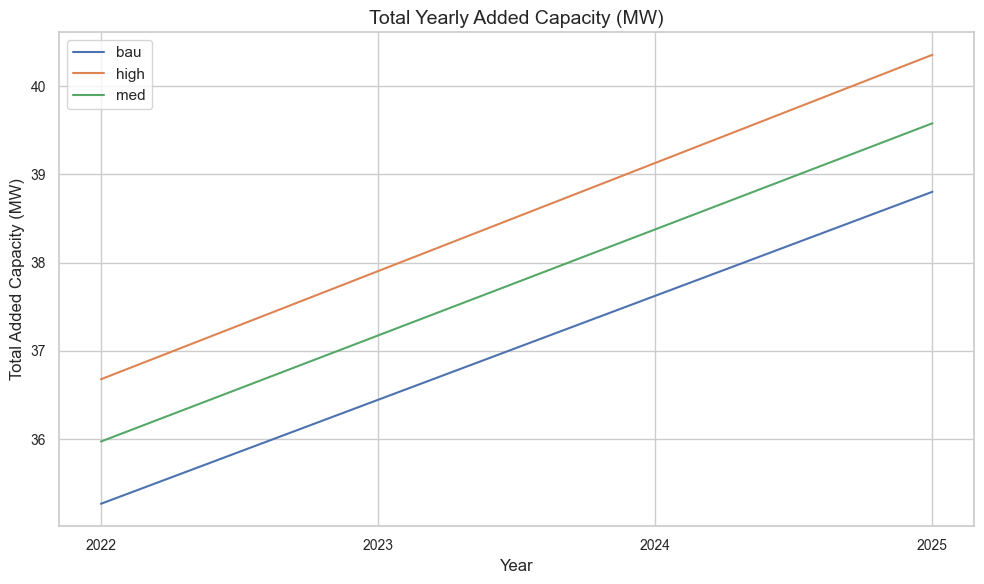

In [119]:

# Calculate the total capacity for each scenario and year
total_capacity = combined_data.groupby(['year', 'scenario'])['kw'].sum()/1000

print(total_capacity.head)

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot average adoption rates for each scenario
for scenario in total_capacity.index.get_level_values('scenario').unique():
    ax.plot(total_capacity.loc[:, scenario], label=scenario)

# Customize gridlines
ax.yaxis.grid(True)
ax.set_axisbelow(True)

# Set labels, title, and font size
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Added Capacity (MW)', fontsize=12)
plt.title('Total Yearly Added Capacity (MW)', fontsize=14)

# Customize font size for tick labels and legend
plt.xticks(total_generation.index.get_level_values('year').unique(), fontsize=10)  # Set xticks with integer values
plt.yticks(fontsize=10)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [175]:
#write output to file for further analysis
census_adoption_geodata = tracts_geodata.merge(predicted_scenario_data, left_index=True, right_on="GEOID")
census_adoption_geodata.to_file('census_adoption_data.geojson', driver='GeoJSON')


In [176]:
#aggregate capacity at state and county levels to use for further analysis in next step
merged_adoption_data = cleaned_data[["state_abbr", "county_name"]].merge(predicted_scenario_data, left_index=True, right_on="GEOID")

tract_adoption_data = merged_adoption_data[['GEOID', 'state_abbr', 'county_name', 'year', 'scenario', 'kw', 'yearly_kwh']]

#Write tracts data for further analysis
tract_adoption_data.to_csv("tract_adoption_data.csv")

print(tract_adoption_data)

             GEOID state_abbr            county_name  year scenario        kw   
18734  53067010600         WA        Thurston County  2021      bau  3.538292  \
62643  53067010600         WA        Thurston County  2022      bau  6.093725   
62644  53067010600         WA        Thurston County  2023      bau  6.093725   
62645  53067010600         WA        Thurston County  2024      bau  6.093725   
62646  53067010600         WA        Thurston County  2025      bau  6.093725   
...            ...        ...                    ...   ...      ...       ...   
77084   6071003404         CA  San Bernardino County  2021     high  3.576262   
77085   6071003404         CA  San Bernardino County  2022     high  3.576262   
77086   6071003404         CA  San Bernardino County  2023     high  3.576262   
77087   6071003404         CA  San Bernardino County  2024     high  3.576262   
77088   6071003404         CA  San Bernardino County  2025     high  3.576262   

        yearly_kwh  
18734 

In [134]:
#only want year 2024 for high scenario
med_2024_data = merged_adoption_data.loc[(merged_adoption_data['year'] == 2024) & (merged_adoption_data['scenario'] == 'med')]

print(merged_adoption_data.loc[(merged_adoption_data['year'] == 2021)].nlargest(10, 'adoption_rate')[["state_abbr", "county_name", "adoption_rate"]])


print("Top 10 Tracts for Solar Capacity (kw) 2024 Med:")
print(merged_adoption_data.loc[(merged_adoption_data['year'] == 2022) & (merged_adoption_data['scenario'] == 'high')].nlargest(10, 'kw')[["state_abbr", "county_name", "kw"]])

print("Top 10 Tracts for Solar Capacity (kw) 2024 High:")
print(merged_adoption_data.loc[(merged_adoption_data['year'] == 2024) & (merged_adoption_data['scenario'] == 'high')].nlargest(10, 'kw')[["state_abbr", "county_name", "kw"]])

      state_abbr            county_name  adoption_rate
38926         CA          Solano County      18.136646
47054         LA         Orleans Parish      16.053019
1879          CA    Contra Costa County       7.930720
5326          CA       Riverside County       7.688947
34482         CA       San Diego County       6.703297
32039         CA      Sacramento County       6.633166
47406         LA         Orleans Parish       6.465101
47654         LA         Orleans Parish       5.589807
5344          CA       Riverside County       5.573770
6263          CA  San Bernardino County       5.487805
Top 10 Tracts for Solar Capacity (kw) 2024 Med:
       state_abbr            county_name          kw
112097         CA          Solano County  330.409938
116681         LA         Orleans Parish  284.889543
109733         CA  San Bernardino County  143.694541
116793         LA         Orleans Parish  115.105822
110369         CA       San Diego County  108.057143
109393         CA      Sacram